In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np
import drnb as nb

time: 5.22 s (started: 2022-09-09 13:12:32 -07:00)


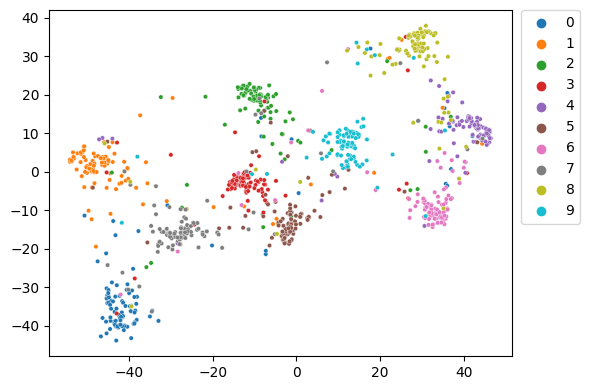

time: 11 s (started: 2022-09-09 12:52:12 -07:00)


In [2]:
s1k_trimap = nb.embed_data("s1k", method="trimap")

TriMap parameters from the [github README](https://github.com/eamid/trimap):

* `n_inliers=12`: number of nearest neighbors.
* `n_outliers=4`: number of outliers for forming the nearest neighbor triplets.
* `n_random=3`: number of random triplets per point.
* `distance="euclidean"`: distance measure, one of: (`"euclidean"` (default), `"manhattan"`, `"angular"` (or `"cosine"`), `"hamming"`).
* `weight_temp=0.5`: temperature of the logarithm applied to the weights. Larger temperatures generate more compact embeddings.
* `lr=0.1`: learning rate.
* `n_iters=400`
* `apply_pca=True`: whether to apply PCA on the input data. Ignored if `distance="hamming"` or there are fewer than 100 dimensions in the input data. Otherwise, the first 100 components from truncated SVD are extracted. Data is centered. If no PCA is applied then data is scaled to 0-1 globally (columns maintain their ratio of variances) and then mean-centered.
* `opt_method="dbd"`: optimization method, one of :`"sd"` (steepest descent), `"momentum"` (steepest descent with momentum), `"dbd"` (delta-bar-delta method like t-SNE).
* `return_seq=False` Store the intermediate results and return the results in a tensor. Coordinates are returned every 10 iterations. It's less easy to control this than with PaCMAP. You can try setting `trimap.trimap_._RETURN_EVERY` to a larger value (e.g. `100` to return every 100 iterations), but from the number of underscores you can see in that expression, I don't think we should rely on that being a stable public API.
* `verbose=False`
* `init=None` Initialization: can be one of `"pca"` (the default, also scales the result by `0.01`) or `"random"` (use the t-SNE-style normal distribution with sdev = 1e-4). A matrix of initial coordinates may also be provided.

TRIMAP(n_inliers=12, n_outliers=4, n_random=3, distance=euclidean, weight_temp=0.5, lr=0.1, n_iters=400, apply_pca=True, opt_method=dbd, verbose=True, return_seq=True)
running TriMap on 1000 points with dimension 9
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100 /  400, Loss: 0.242, Violated triplets: 11.2941
Iteration:  200 /  400, Loss: 0.235, Violated triplets: 11.3392
Iteration:  300 /  400, Loss: 0.232, Violated triplets: 11.3196
Iteration:  400 /  400, Loss: 0.229, Violated triplets: 11.2745
Elapsed time: 0:00:01.090540


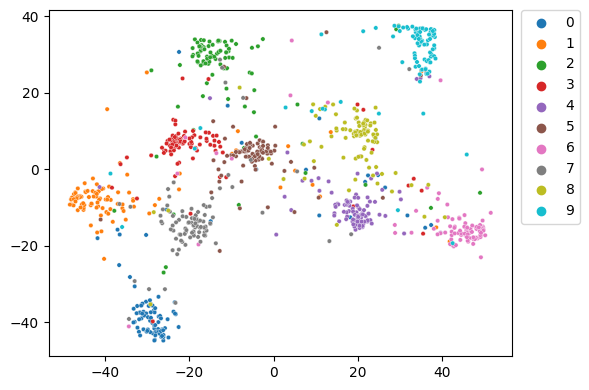

time: 1.48 s (started: 2022-09-04 15:48:59 -07:00)


In [3]:
s1k_trimap = nb.embed_data(
    "s1k",
    method=nb.embedder("trimap", params=dict(verbose=True, return_seq=True)),
)

Here's a look at the number of snapshots you get back by default:

In [4]:
s1k_trimap["snapshots"].keys()

dict_keys(['it_0', 'it_10', 'it_20', 'it_30', 'it_40', 'it_50', 'it_60', 'it_70', 'it_80', 'it_90', 'it_100', 'it_110', 'it_120', 'it_130', 'it_140', 'it_150', 'it_160', 'it_170', 'it_180', 'it_190', 'it_200', 'it_210', 'it_220', 'it_230', 'it_240', 'it_250', 'it_260', 'it_270', 'it_280', 'it_290', 'it_300', 'it_310', 'it_320', 'it_330', 'it_340', 'it_350', 'it_360', 'it_370', 'it_380', 'it_390', 'it_400'])

time: 4.61 ms (started: 2022-09-04 15:49:01 -07:00)


That's a lot. The current version of TriMap (1.1.4) [has a bug](https://github.com/eamid/trimap/issues/23) which means the initial output at `it_0` isn't correctly returned, so here's iteration 10 instead:

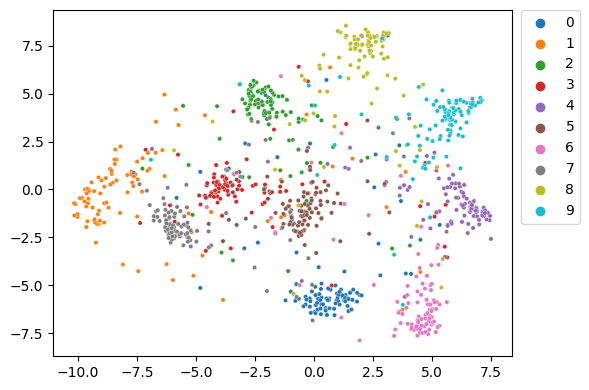

time: 408 ms (started: 2022-09-04 15:49:52 -07:00)


In [7]:
import drnb.plot as nbplot
import drnb.io as nbio

nbplot.sns_embed_plot(s1k_trimap["snapshots"]["it_10"], nbio.read_datay("s1k"))

Here's an example of (unwisely) using the internal `RETURN_EVERY` setting to produce fewer snapshots of the coordinates:

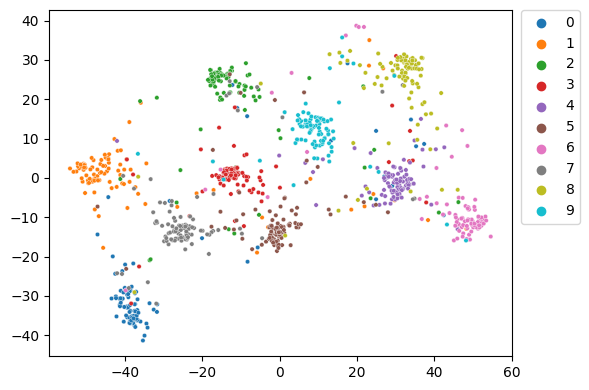

time: 1.47 s (started: 2022-09-04 15:49:56 -07:00)


In [8]:
import trimap

trimap.trimap_._RETURN_EVERY = 100
s1k_trimap_every100 = nb.embed_data(
    "s1k", method=nb.embedder("trimap", params=dict(return_seq=True))
)

In [9]:
s1k_trimap_every100["snapshots"].keys()

dict_keys(['it_0', 'it_100', 'it_200', 'it_300', 'it_400'])

time: 3.33 ms (started: 2022-09-04 15:49:57 -07:00)


As you can see, we have returned a more manageable set of snapshots. We should remember to change that setting back though:

In [10]:
trimap.trimap_._RETURN_EVERY = 10

time: 847 µs (started: 2022-09-04 15:50:01 -07:00)


If you are convinced this is a good idea, you may provide a `return_every` argument when creating the embedder and it will set this entry for you and change it back. I make no claim it's foolproof if an exception is thrown in the middle of the calculation. Note that you *don't* pass this parameter to the `params` dictionary as it is not part of the trimap API and trimap won't know what to do with it, i.e. do this:

```python
# Good
nb.embedder("trimap", return_every=200, params=dict(return_seq=True))
```

and **do not** do this:

```python
# BAD
nb.embedder("trimap", params=dict(return_seq=True, return_every=200))
```

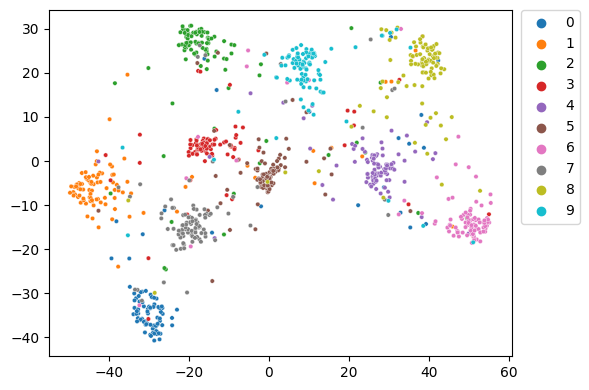

time: 11.3 s (started: 2022-09-09 13:12:37 -07:00)


In [2]:
s1k_trimap_every200 = nb.embed_data(
    "s1k",
    method=nb.embedder("trimap", return_every=200, params=dict(return_seq=True)),
    export=("csv", dict(sub_dir="trimap")),
)

Check it worked:

In [12]:
s1k_trimap_every200["snapshots"].keys()

dict_keys(['it_0', 'it_200', 'it_400'])

time: 3.94 ms (started: 2022-09-04 15:50:06 -07:00)


And `RETURN_EVERY` should be back to normal:

In [13]:
trimap.trimap_._RETURN_EVERY

10

time: 4.45 ms (started: 2022-09-04 15:50:10 -07:00)
